# Optimizing test-set diversity: Trajectory clustering for scenario-based testing of automated driving systems 


In [1]:
# Import packages
from scipy.ndimage import gaussian_filter
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import random
import scipy.cluster.hierarchy as scch
import scipy
from sklearn.mixture import GaussianMixture

# for extensions
from sklearn.cluster import DBSCAN, KMeans

import matplotlib as mpl

### Loading trajectory data-set and ground truth labels (if-available)

For the model, the trajectory data-set should be a list with $k$ trajectories:

Each trajectory is an $n_i \times 2$ numpy array, with $n_i$ being the number of observations of the trajectory:
$$
\begin{pmatrix}
 x_1 & y_1 \\
  ... & ... \\
 x_{n_i} & y_{n_i} \\
\end{pmatrix}
$$

For evaluation, the set of labels should be a list $\{l_1,...,l_{k}\}$, with $l_i$ being the label of trajectory $i$.

In [2]:
trajectory_data = sio.loadmat('TrajData.mat')
traj_list_T15 = list()
gt_list_T15 = list()
for trajectory in trajectory_data['DataHu2']:
    traj_list_T15.append(trajectory[0][0])
    gt_list_T15.append(trajectory[0][1][0][0])
    

### Set variables and parameters for model

In [3]:
# 1) trajectory list for clustering
trajectories_raw = traj_list_T15

# 2) ground truth list for clustering evaluation (if available)
ground_truth = gt_list_T15

# 3.a) number of clusters in first-stage clustering (Gaussian Mixture Model)
k_GMM = 220
# 3.b.i) number of clusters in second stage clustering (hierarchical clustering)
k_HC= 15
# 3.b.ii) alternative: threshold for hierarchical clustering (substitute code bellow)
#threshold_HC = 0.2

# 4) lambda value for direction weight (if fixed lambda is used)
weigth_direction = 50

# 5) noise level (variance of Gaussian noise)
noise_point = 0.0

# 6) leap size between coordinate observations to calculate driving direction
shift = 40

# 7) filter value for Gaussian smoothing
gaus_filter = 30

# 8) number of interpolation steps  
interpolation_steps = 10

# 9) for visualization: limits for x and y axis
x_limits=[0,325]
y_limits=[0,250]

### Data pre-processing -> interpolation and smoothing (Gaussian filter)

In [4]:
# set list for processed trajectories
trajectory_list = []

# for each trajectory
for track in trajectories_raw:
    # get number of observations
    number_points = np.shape(track)[0]
    # perform interpolation
    transformed_trajectory = np.zeros((2,interpolation_steps*number_points))     
    transformed_trajectory[0,:] = np.interp(np.linspace(1,number_points,interpolation_steps*number_points), np.linspace(1,number_points,number_points), track[:,0])
    transformed_trajectory[1,:] = np.interp(np.linspace(1,number_points,interpolation_steps*number_points), np.linspace(1,number_points,number_points), track[:,1])
    # perform gaussian filter
    transformed_trajectory[0,:] = scipy.ndimage.gaussian_filter(transformed_trajectory[0,:],gaus_filter)
    transformed_trajectory[1,:] = scipy.ndimage.gaussian_filter(transformed_trajectory[1,:],gaus_filter)
    # append to list
    trajectory_list.append(transformed_trajectory)

### Data Prep for first-stage clustering

For every observation: the driving direction is calculated and the vehicle state is added to a data-set.

This data-set is used for fitting the Gaussian-Mixture model.

In [5]:
# list for trajectory-points and list for corresponding trajectory-ID (for histogram creation later)
data_points_list = list()
traj_index_list = list()


# for each trajectory 
for i in range(len(trajectory_list)):
    traj = trajectory_list[i]

    # for each time step of the trajectory (except excess points)
    for j in range(len(traj[0])-shift):

        # create empty data-point
        point = np.zeros((4))

        # add noise to coordinate
        point[0] = traj[0][j+shift]+random.normalvariate(0, noise_point)
        point[1] = traj[1][j+shift]+random.normalvariate(0, noise_point)

        # direction vector (normalized)
        direction = np.zeros((2))
        direction[0] = traj[0][j]-traj[0][j+shift]
        direction[1] = traj[1][j]-traj[1][j+shift]
        direction = direction/np.sqrt((np.square(direction[0]) + np.square(direction[1])))

        # add to time-step array
        point[2:4] = direction*weigth_direction


        # append data point and trajectory index
        data_points_list.append(point)
        traj_index_list.append(i)


### First-stage clustering and visualization

Gaussian Mixture Clustering or KMeans

In [6]:
clustering_first_level = GaussianMixture(n_components=k_GMM, covariance_type = 'spherical', max_iter=30, n_init = 3).fit(data_points_list) 
#clustering_first_level = KMeans(n_clusters=k_GMM).fit(data_points_list) 
labels_ = clustering_first_level.predict(data_points_list)

(array([  0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

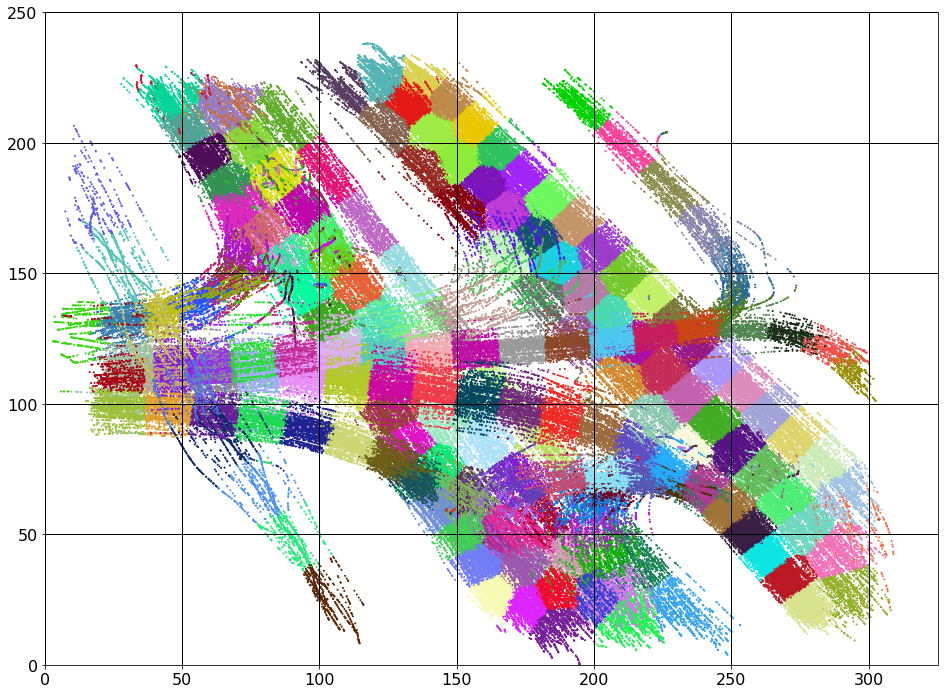

In [7]:
# visualization    
codebook = np.random.randint(255,size=(500,3))/255 # random colors

# only print fraction of points 
printed_points = np.random.uniform(low=0.0, high=1.0, size=len(labels_))>0.8

plt.figure(figsize=(16,12))
x_scatter_axis = np.zeros((len(labels_)))
y_scatter_axis = np.zeros((len(labels_)))
color_encoding = np.zeros((len(labels_),3))

for i in range(len(labels_)):
    x_scatter_axis[i] = data_points_list[i][0]
    y_scatter_axis[i] = data_points_list[i][1]
    color_encoding[i] = codebook[labels_[i]-1]
    
plt.grid(color= [0,0,0], linestyle='-', linewidth=1)
plt.scatter(x_scatter_axis[printed_points],y_scatter_axis[printed_points], s = 1.0, color= color_encoding[printed_points])
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Histogram creation

Transform each trajectory to a histogram, depending on the GMM cluster assignments.

In [8]:
# list for histogram representations
traj_histogram_list = list()

# list to array with 
traj_id_array = np.asarray(traj_index_list)

# for each trajectory in data-set
for i in range(max(traj_id_array)+1):

    # vehicle states where trajectory id is equal to i
    where_traj_id_equal_i = np.where(traj_id_array==i)

    # build histogram for ids
    histogram = np.histogram(labels_[where_traj_id_equal_i], bins=max(labels_), range=(0,max(labels_)))[0]

    # save normalized histograms
    traj_histogram_list.append(histogram/(np.sum(histogram)))

### Second-stage clustering and visualization

Apply hierarchical clustering to histogram representations.

Optional extension: Kmeans on histogram representation 

In [9]:
# build distance matrix
distance_matrix_chi_sqr = np.zeros((len(traj_histogram_list),len(traj_histogram_list)))

# calculate distance matrix
for i in range(0,len(traj_histogram_list)):
    for j in range(i+1,len(traj_histogram_list)):

        vec_list_i = (traj_histogram_list[i])
        vec_list_j = (traj_histogram_list[j])

        # calculate chi^2 distance
        cond_vector = np.where(vec_list_i+vec_list_j != 0)[0]
        numerator = np.square(vec_list_i[cond_vector]-vec_list_j[cond_vector])
        denumerator = (vec_list_i[cond_vector]+vec_list_j[cond_vector])
        chi_square = 0.5*np.sum(numerator/denumerator)

        # fill distance into matrix
        distance_matrix_chi_sqr[i,j] = chi_square
        distance_matrix_chi_sqr[j,i] = distance_matrix_chi_sqr[i,j] 

In [10]:
# perform stage 2 clustering 
linkage_result_trajectories = scch.linkage(distance_matrix_chi_sqr, method='centroid')
# using fixed number of cluster
clustering_second_level = scch.fcluster(linkage_result_trajectories,criterion='maxclust',t=k_HC) 
# using threshold
#clustering_second_level = scch.fcluster(linkage_result_trajectories,criterion='distance',t=threshold_HC) 

c:\users\z663426\appdata\local\continuum\anaconda3\envs\carla\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


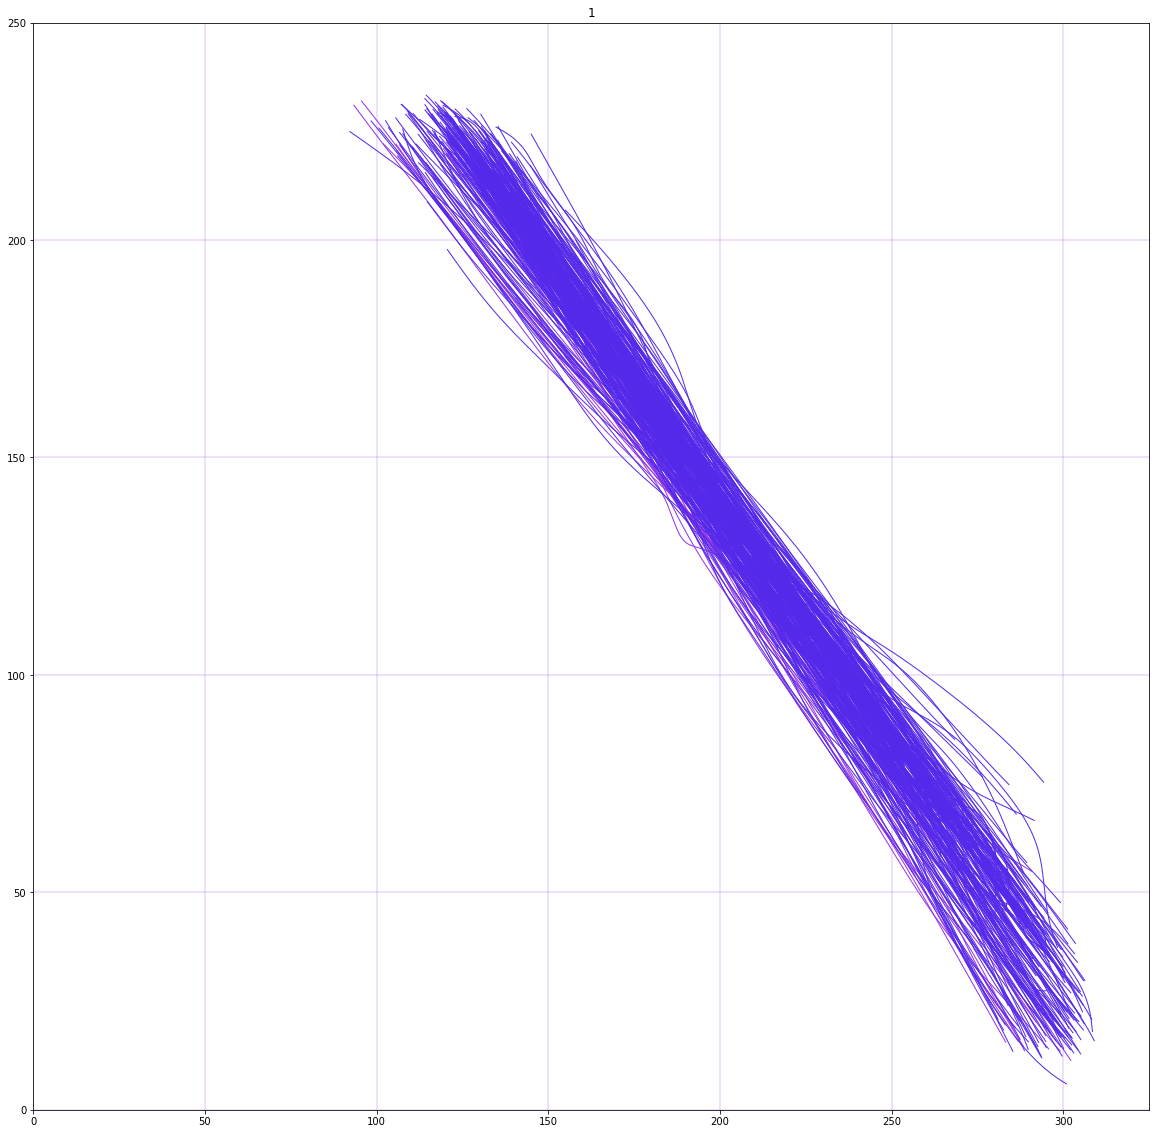

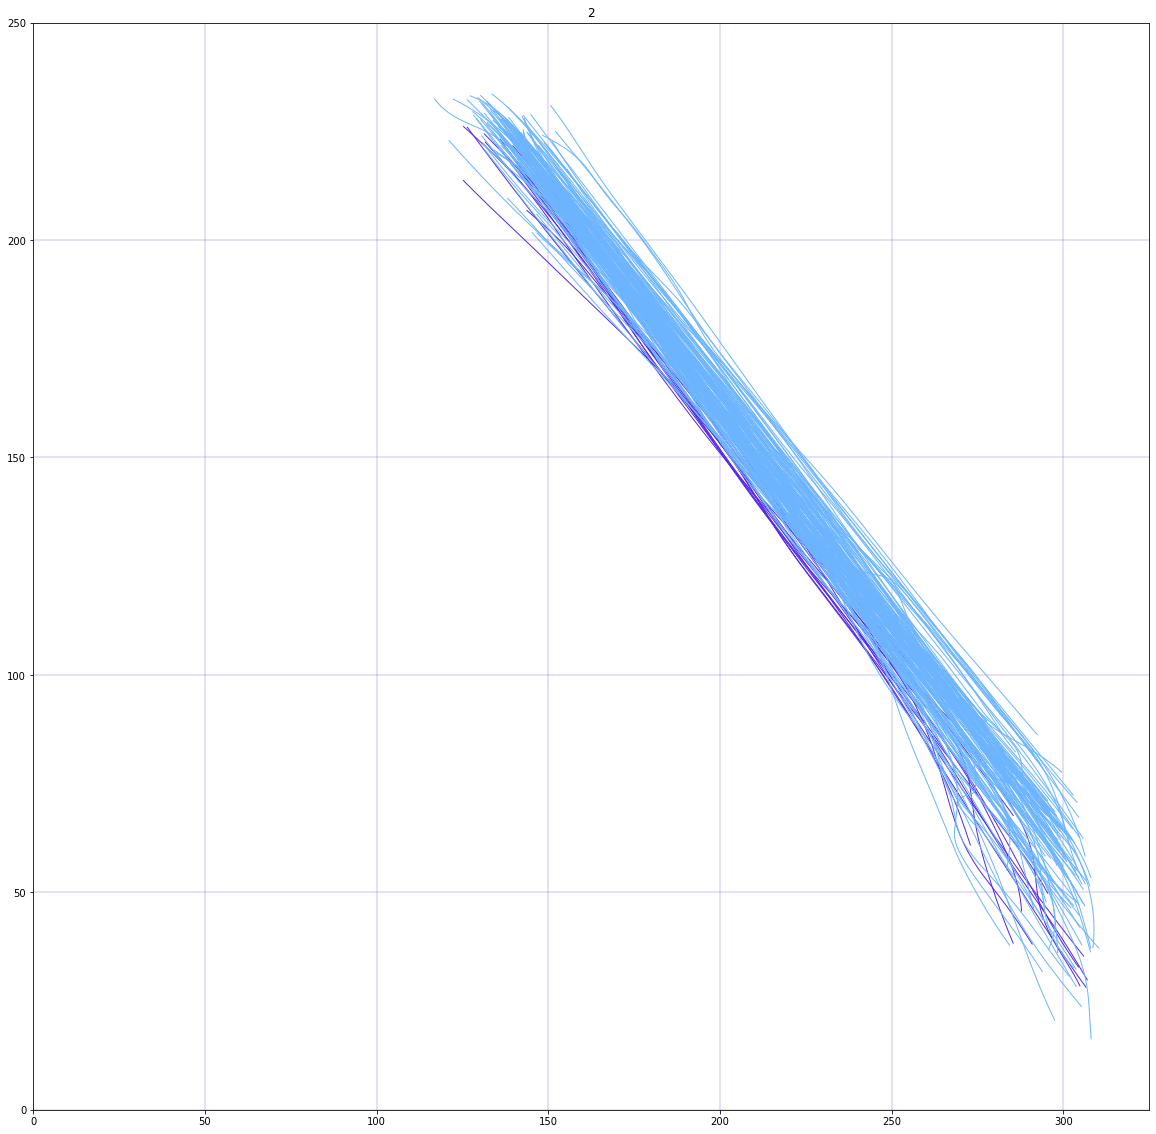

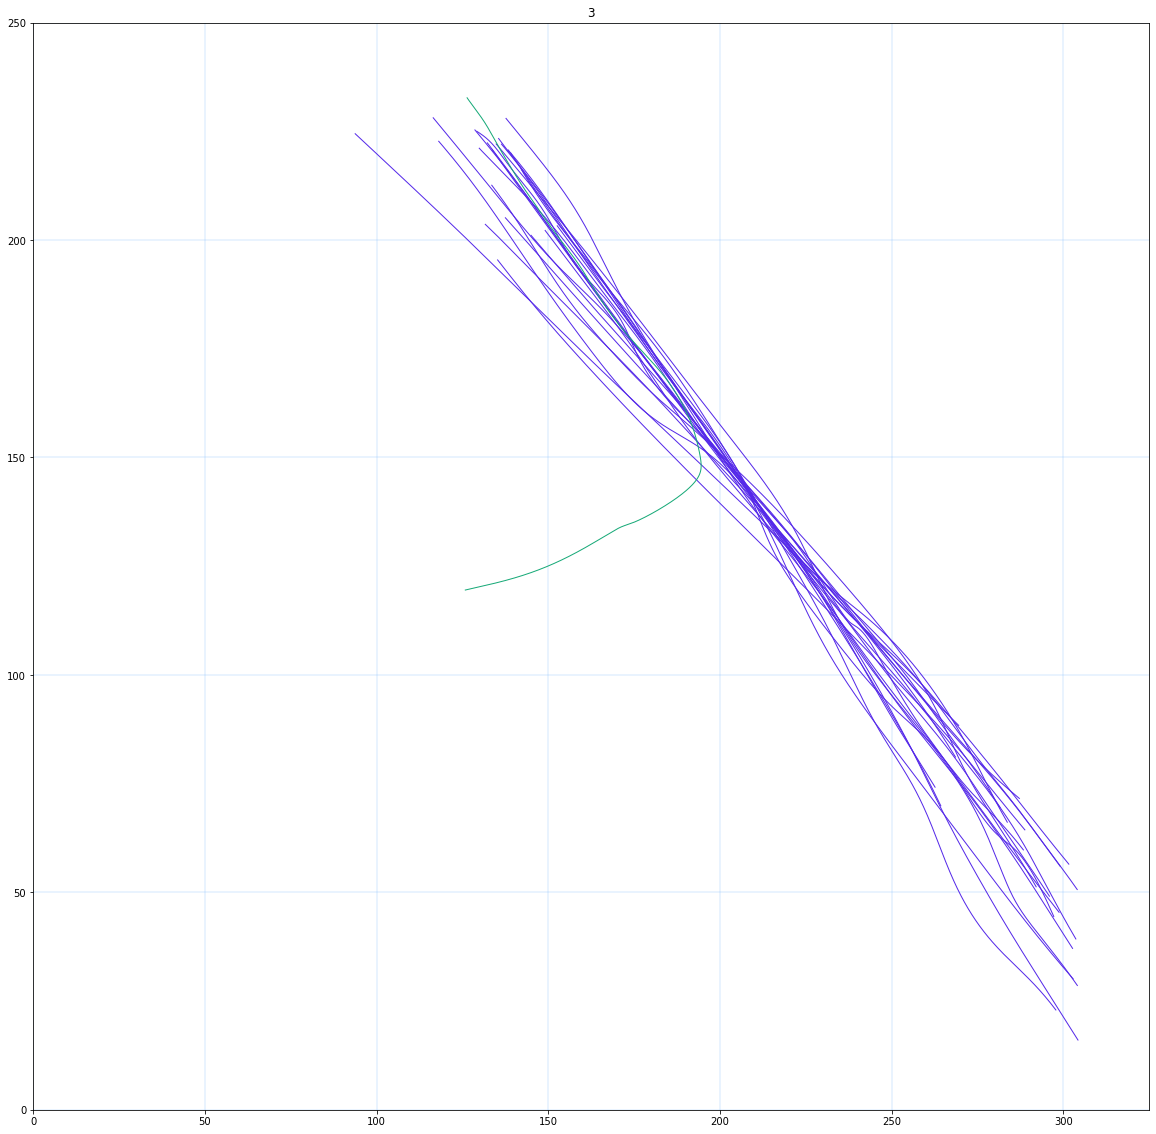

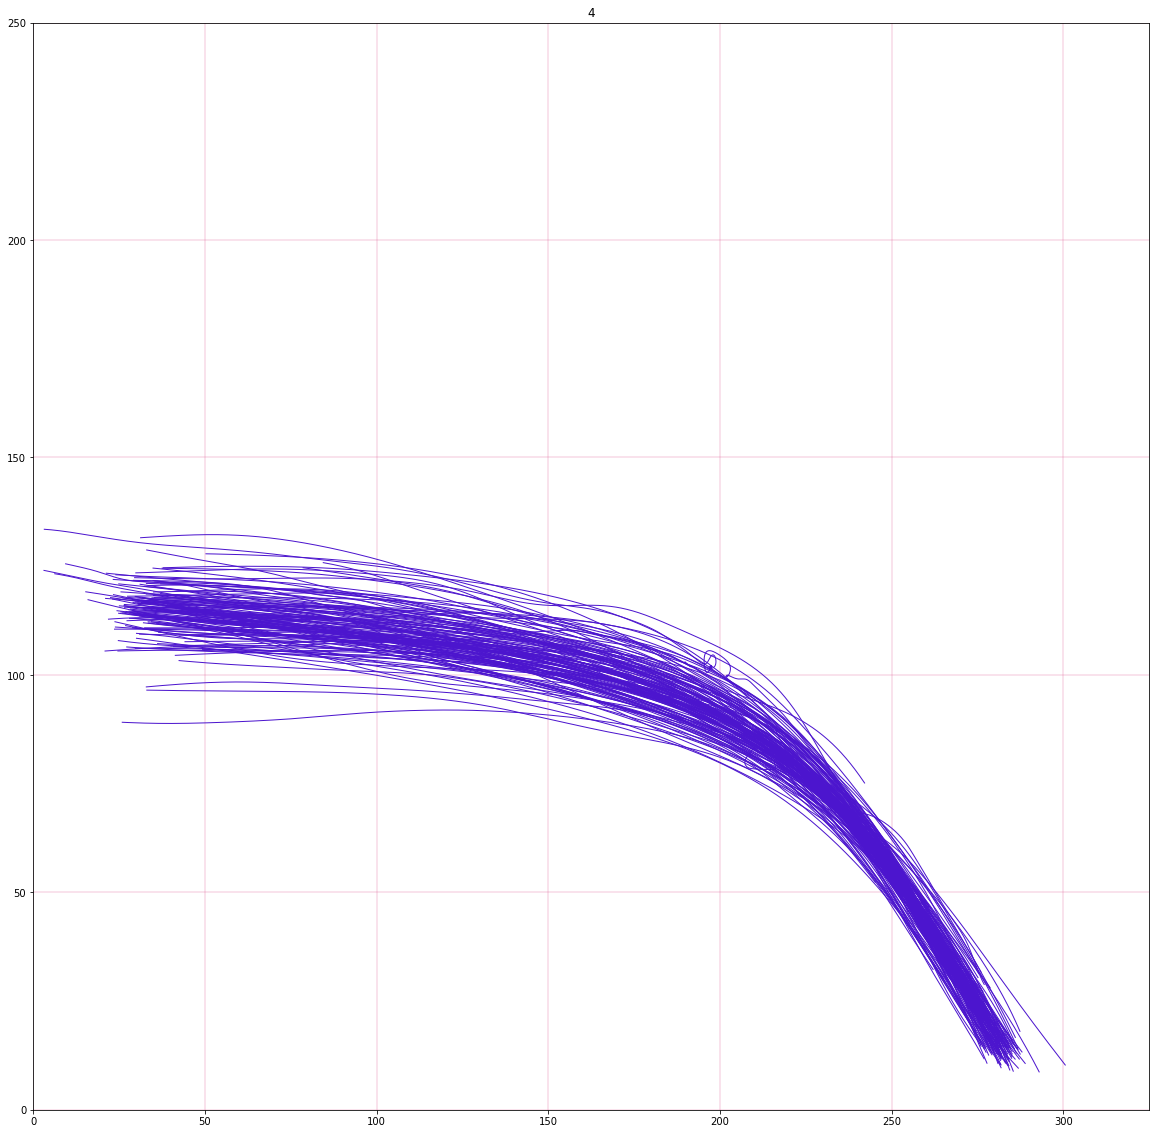

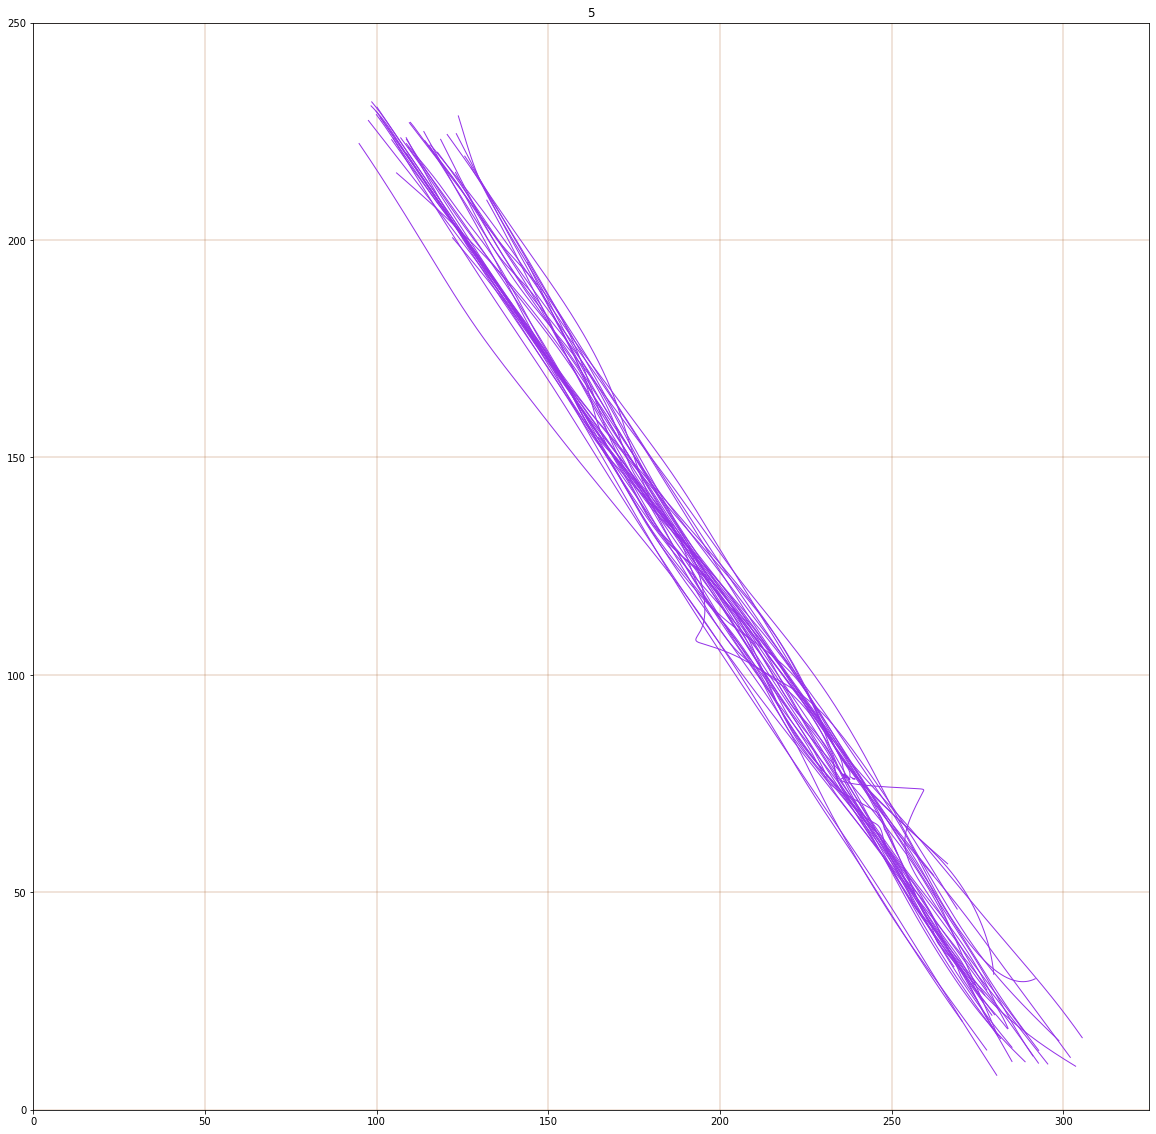

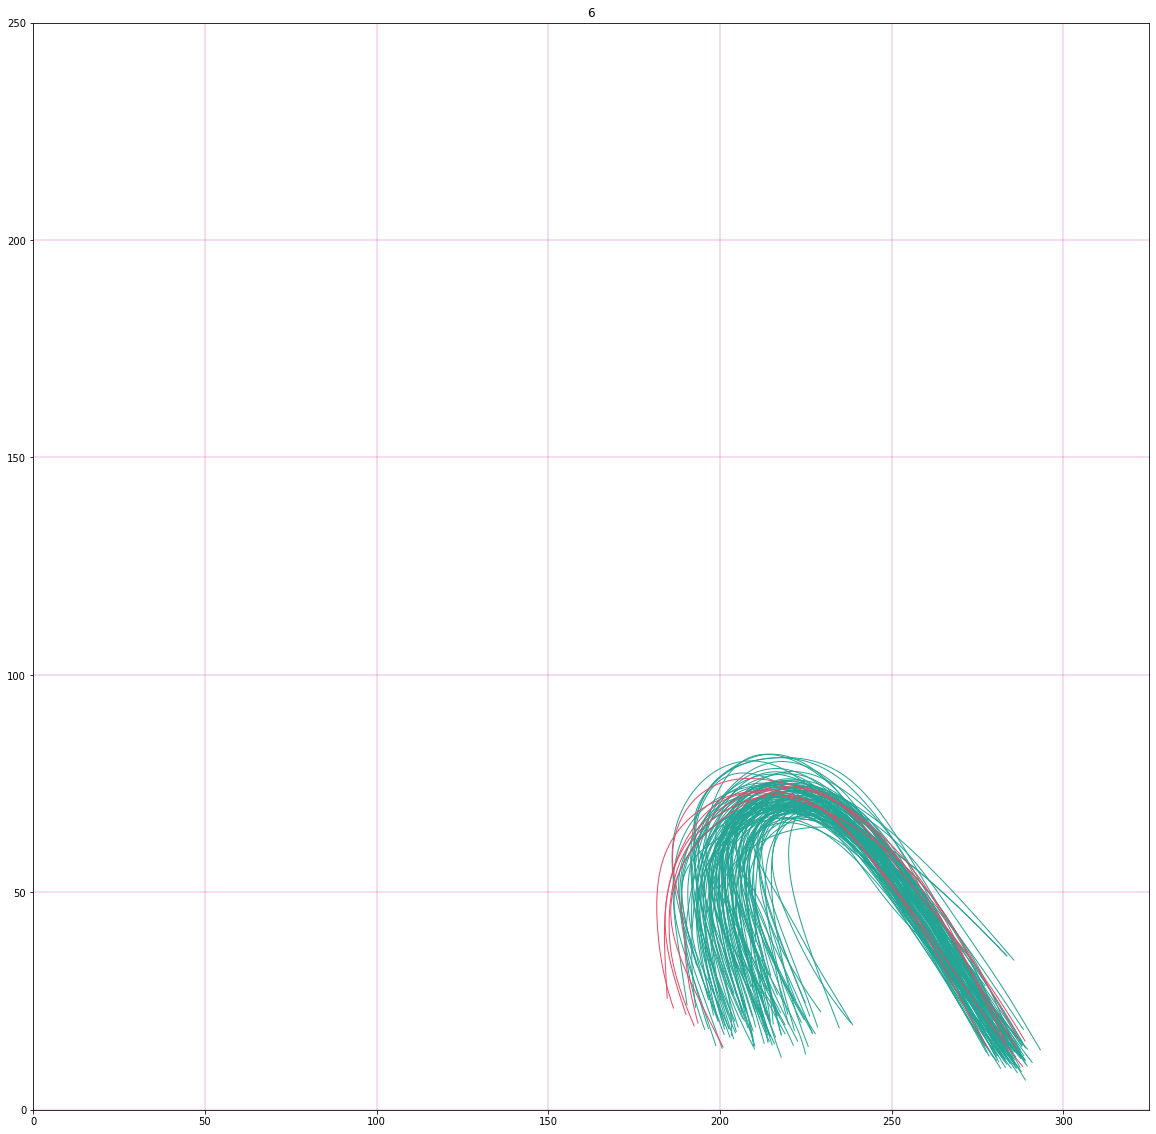

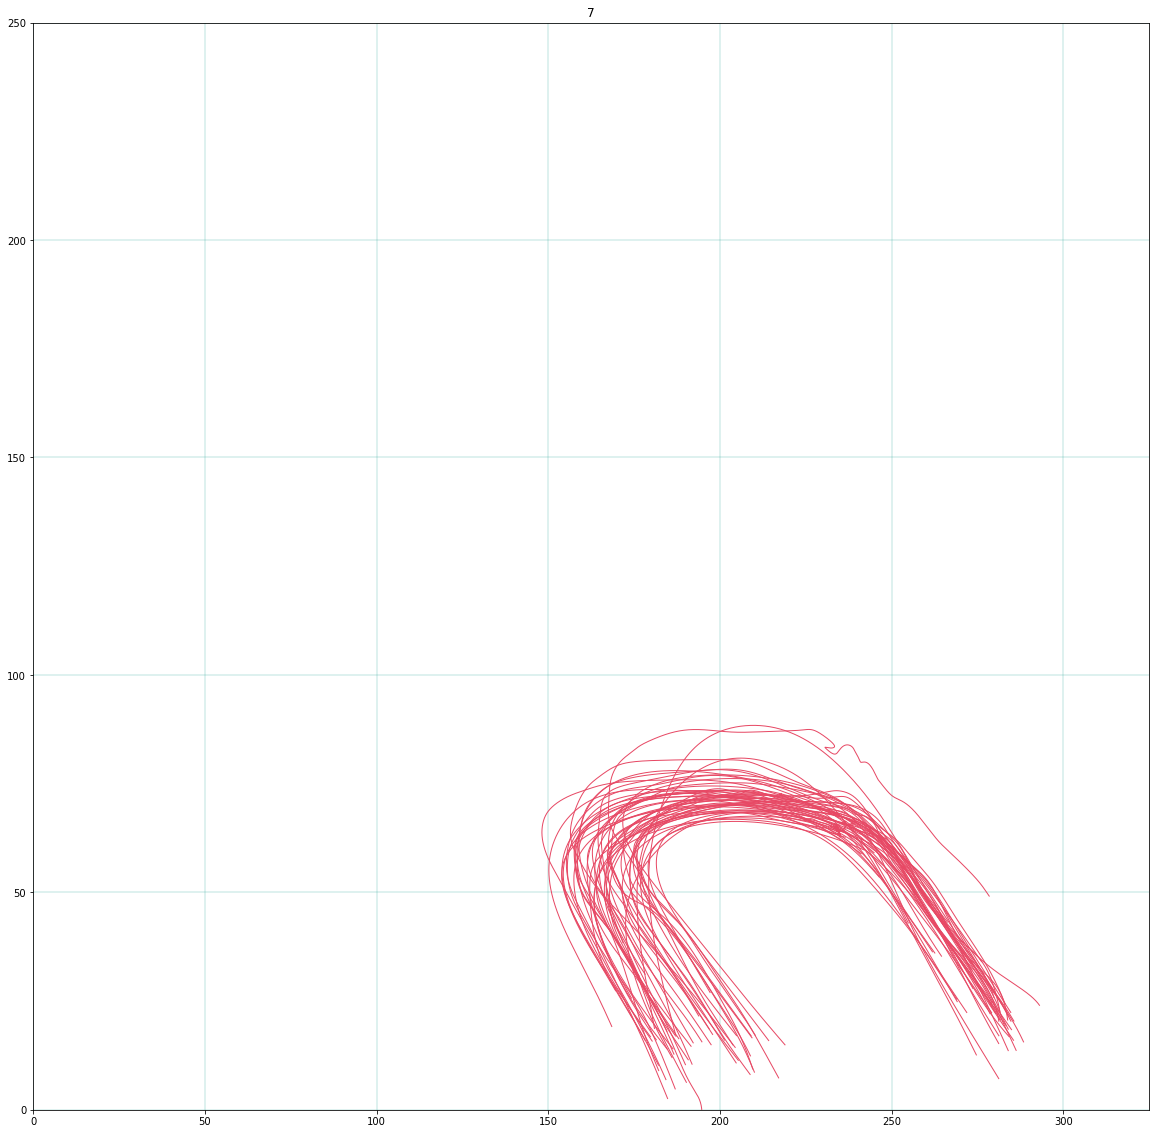

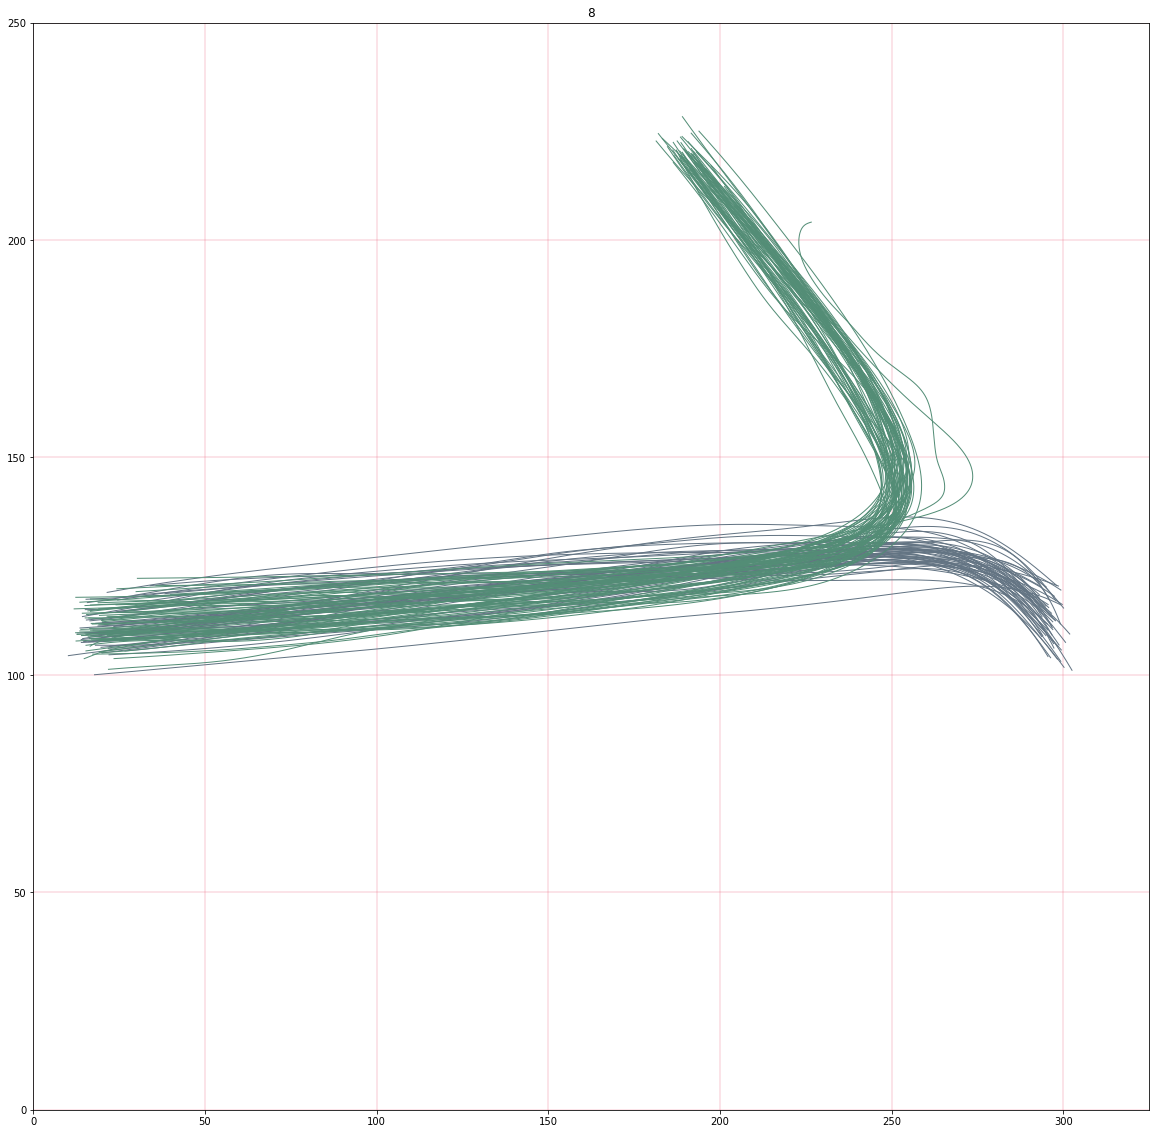

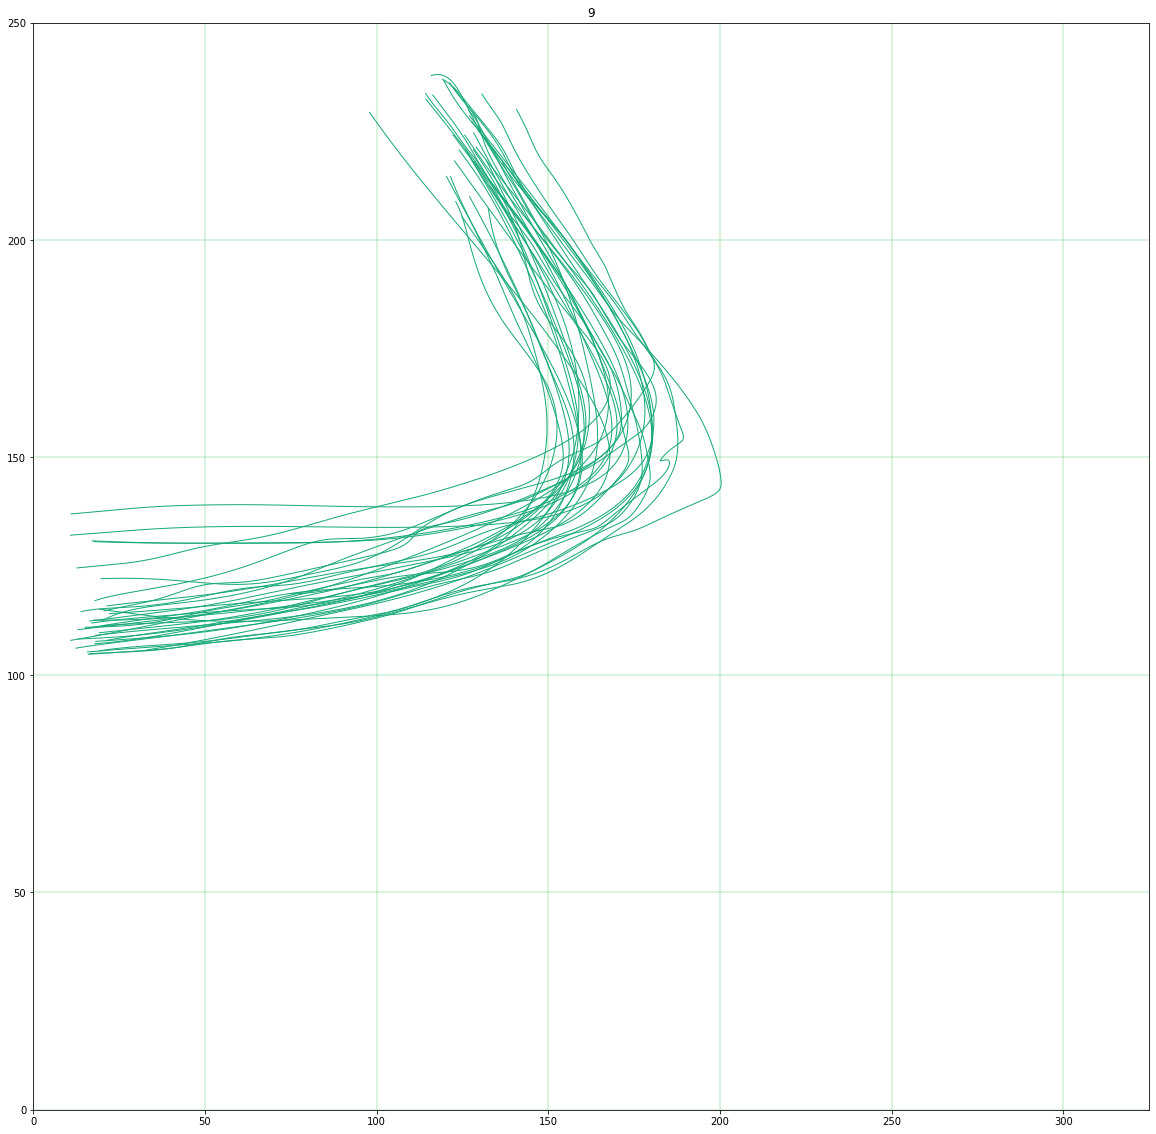

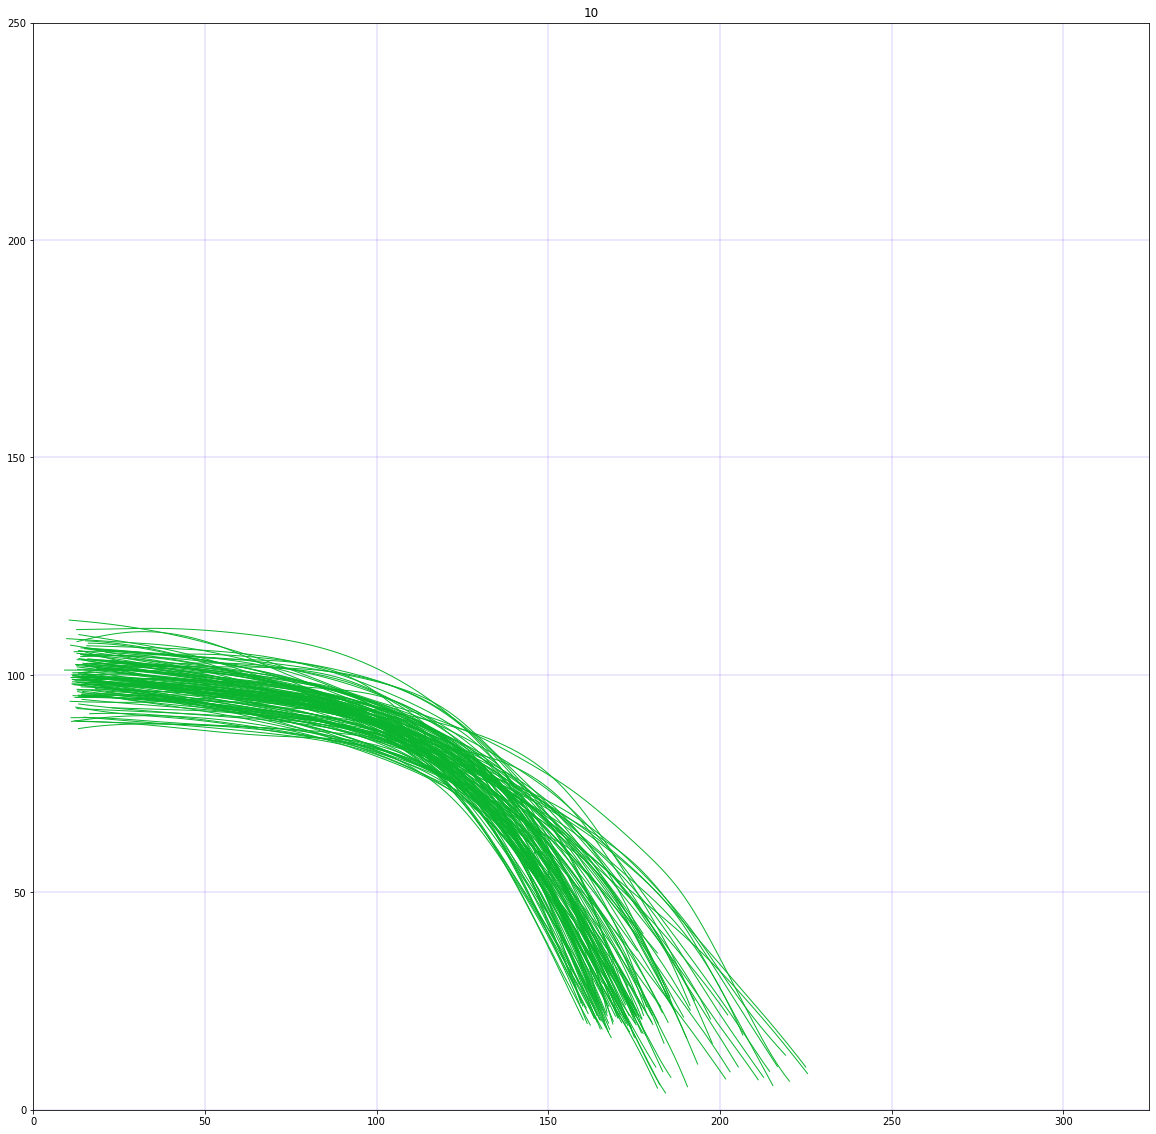

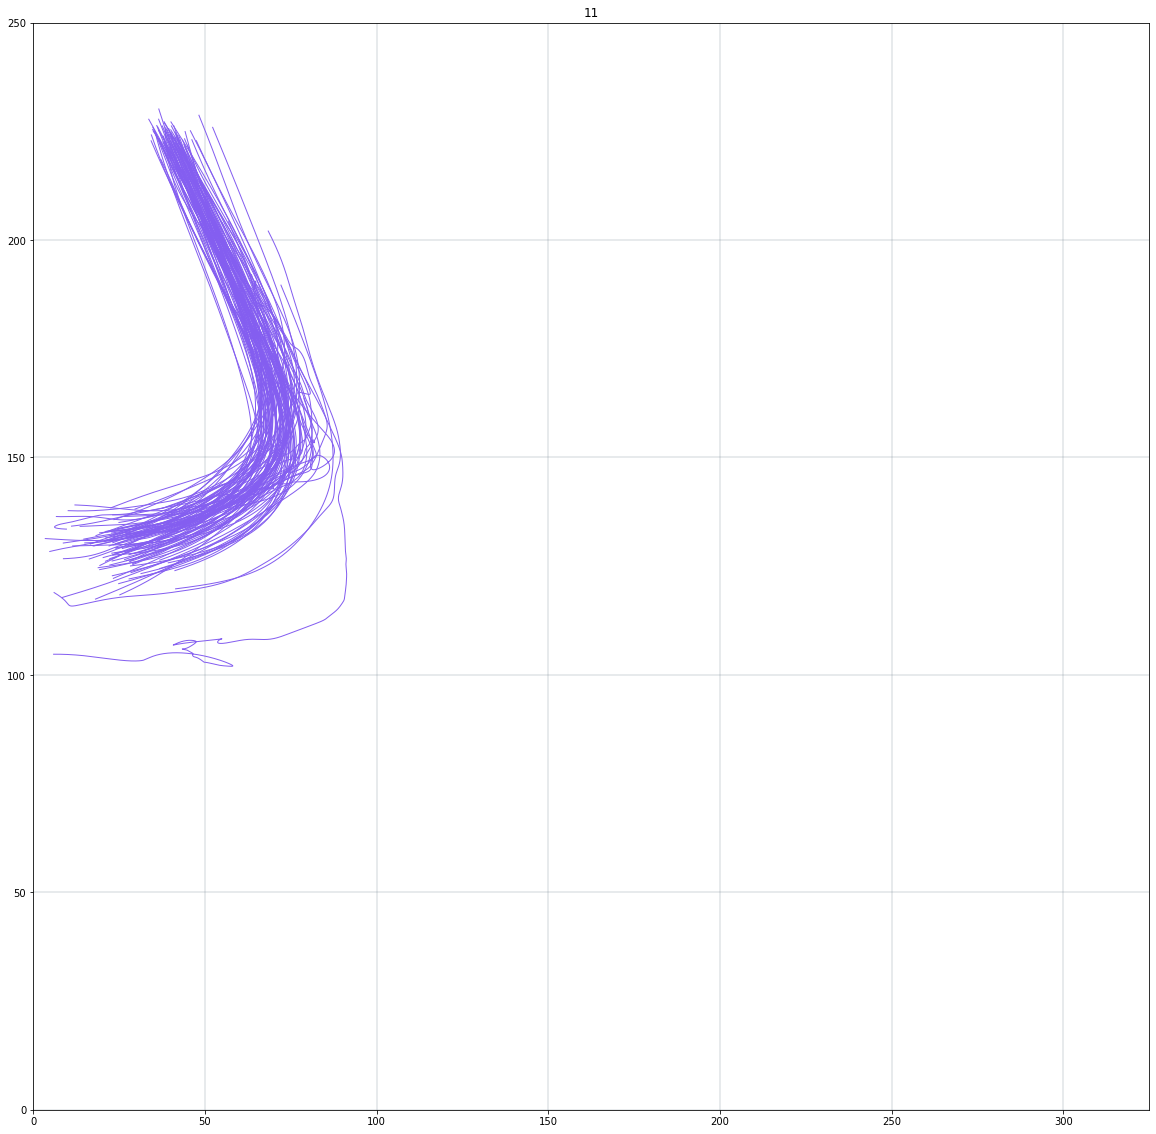

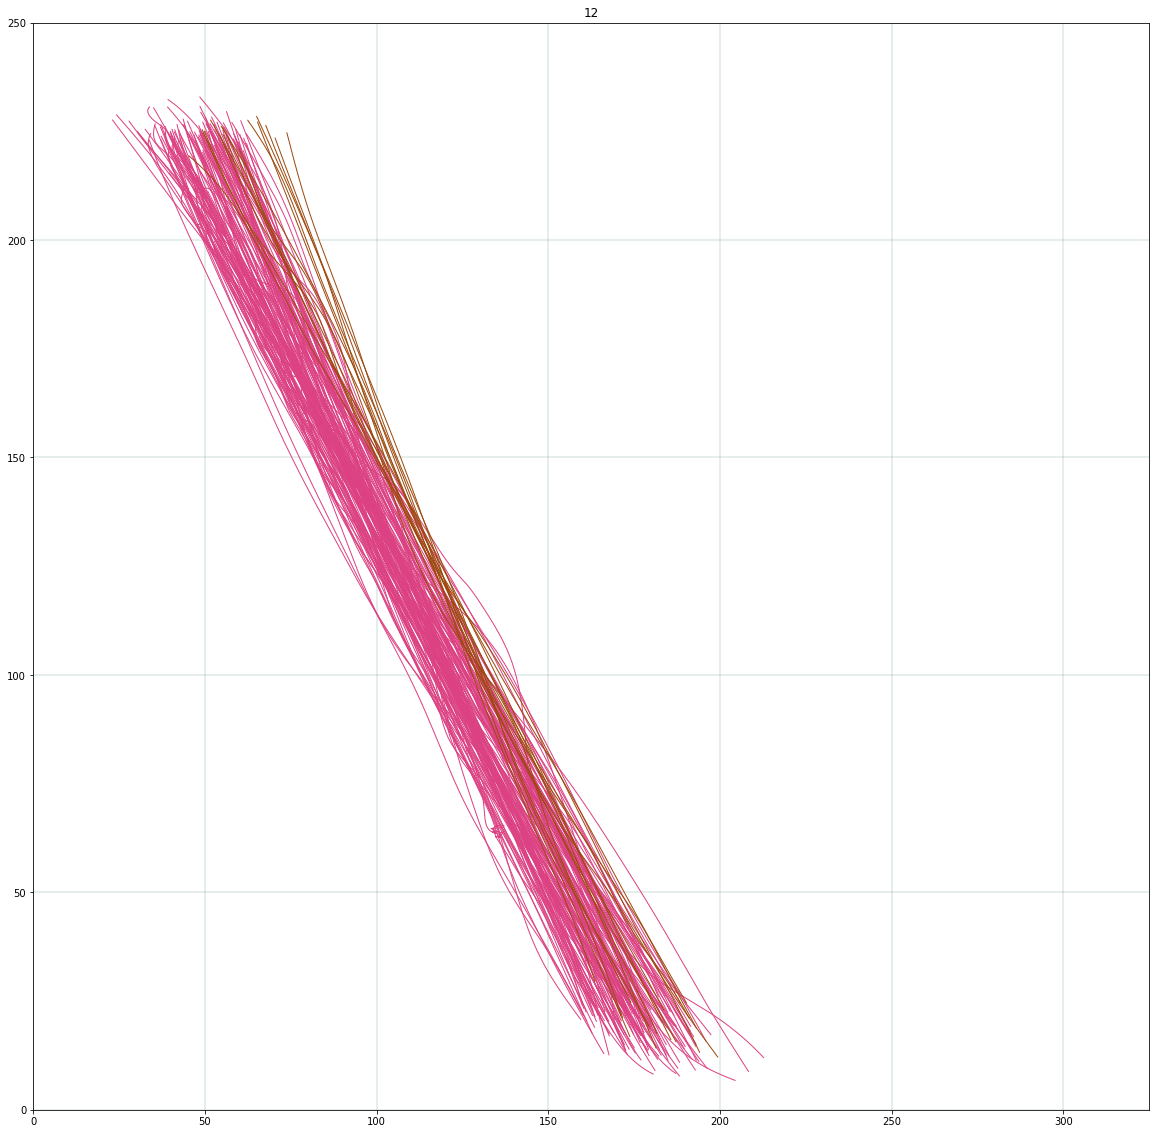

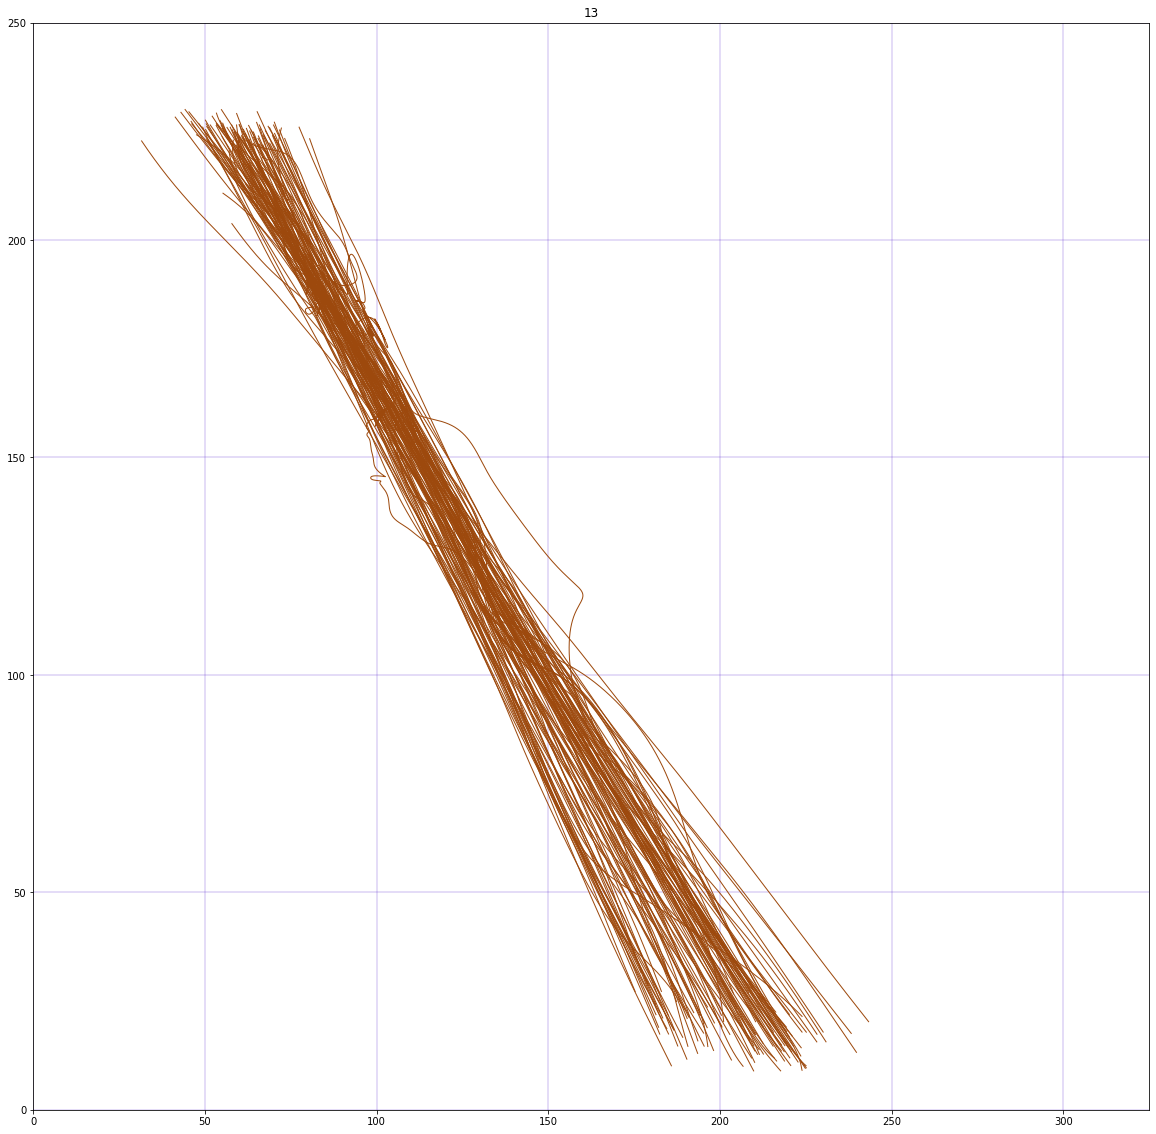

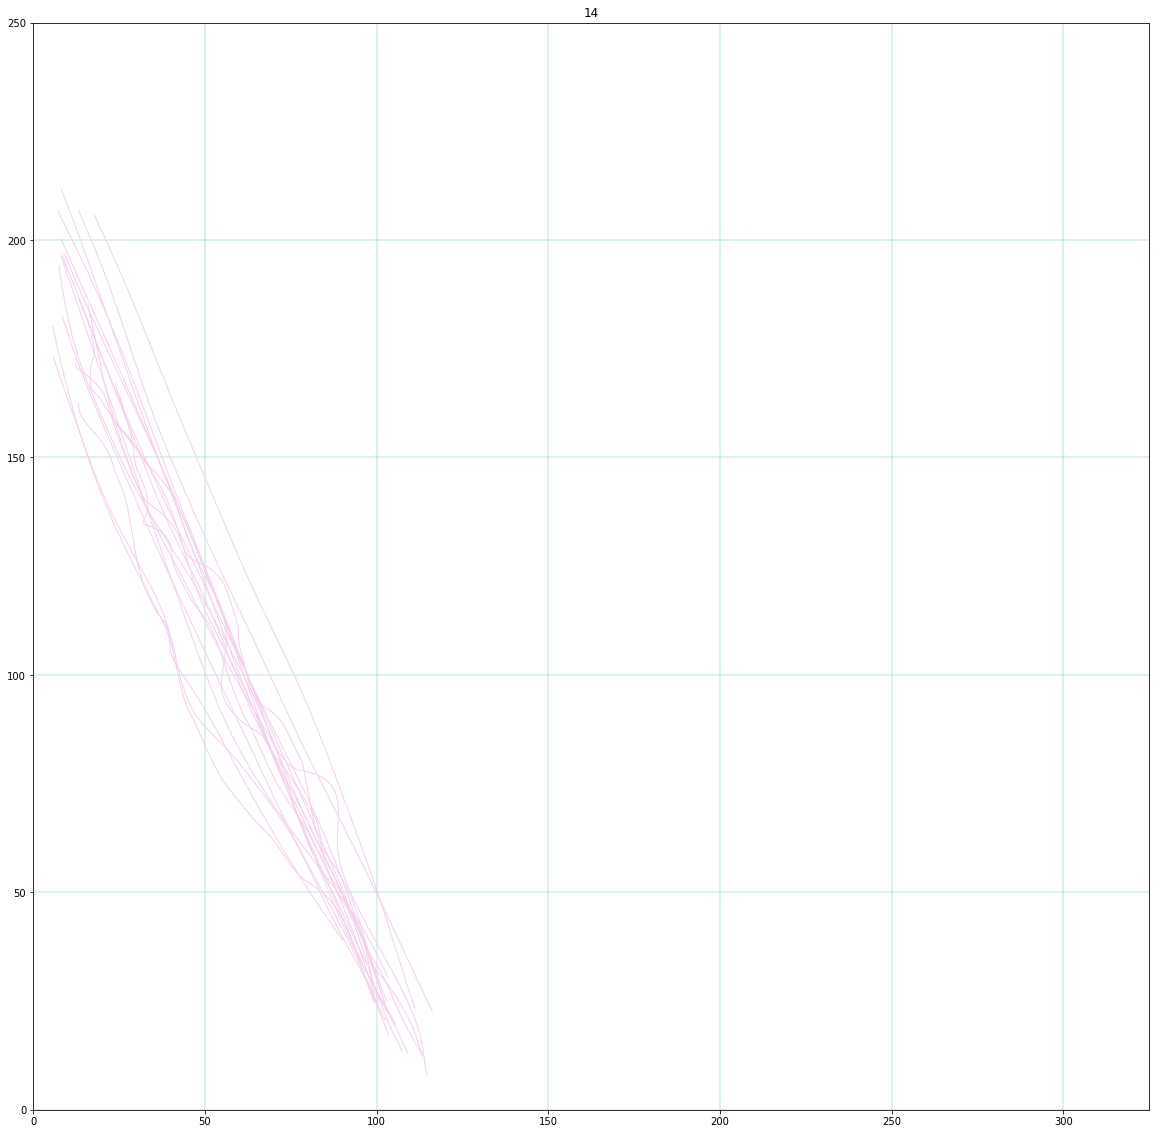

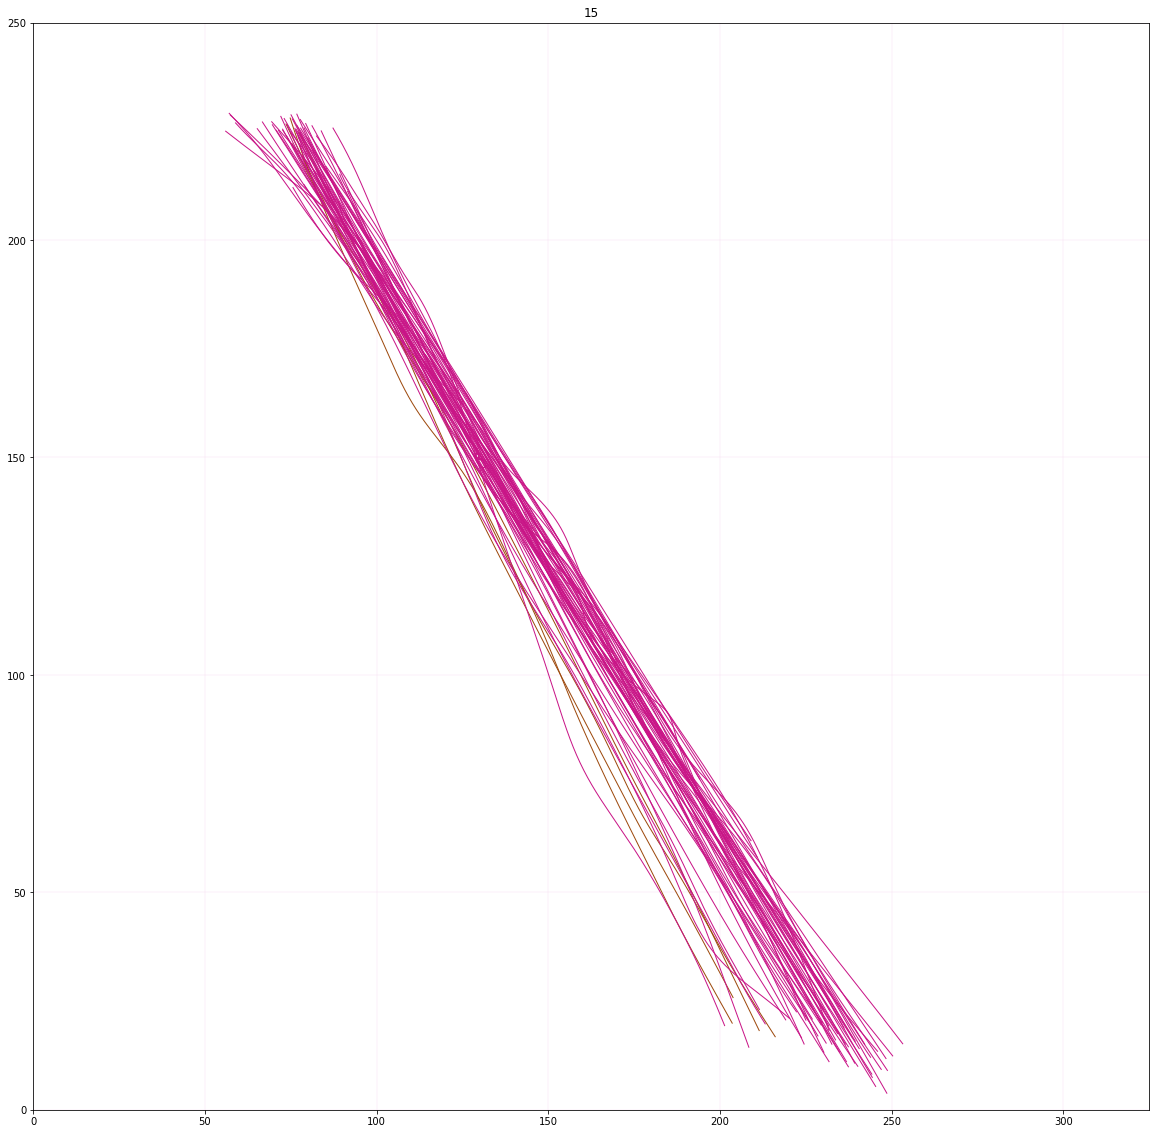

In [11]:
# visualize the trajectory clusters

codebook = np.random.randint(255,size=(500,3))/255

for cluster in range(1,max(clustering_second_level)+1):
    plt.figure(figsize = (20,20))
    j = 0
    for i in np.where(clustering_second_level == cluster)[0]:
        j = j+1
        plt.plot(trajectory_list[i][0],trajectory_list[i][1],color= codebook[int(ground_truth[i])], linewidth=1)
        plt.xlim(x_limits)
        plt.ylim(y_limits)
        plt.grid(color= codebook[clustering_second_level[i]], linestyle='-', linewidth=0.3)
    plt.title(cluster)


### Evaluate CCR if labels are available

In [15]:
# define cost matrix for Hungarian method
cost_matrix=np.zeros((k_HC,k_HC))

# fill cost matrix according to predicted label (x - axis) and ground truth label (y axis)
for i in range(len(clustering_second_level)):
    cost_matrix[clustering_second_level[i]-1,int(ground_truth[i])-1] = cost_matrix[clustering_second_level[i]-1,int(ground_truth[i])-1]+1

# calculate optimal assignment
matching_result = scipy.optimize.linear_sum_assignment(-cost_matrix)

# calculate ccr
ccr_value = np.sum(cost_matrix[matching_result[0],matching_result[1]])/len(clustering_second_level)

print("CCR-Score: " + str(ccr_value))

CCR-Score: 0.9106666666666666
